# 과제1. 흉부 엑스레이 이미지 데이터 세트(Chest X-ray Images Dataset)
- Draft written by Seunghun Shin, revised by Hyeonseung Im
- link : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 데이터(2GB) 다운로드 후 Google Drive에 업로드

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2
import seaborn as sns
from PIL import Image
import random

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams
import matplotlib.pyplot as plt
from tqdm import tqdm

import os

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
tf.random.set_seed(seed)

In [2]:
# 구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기

In [3]:
# Google Drive에 업로드한 데이터셋의 압축 풀기
!unzip /content/drive/MyDrive/Data/chest_x-ray/archive.zip

unzip:  cannot find or open /content/drive/MyDrive/Data/chest_x-ray/archive.zip, /content/drive/MyDrive/Data/chest_x-ray/archive.zip.zip or /content/drive/MyDrive/Data/chest_x-ray/archive.zip.ZIP.


In [5]:
DIR = os.listdir('/content/drive/MyDrive/chest_xray')
labels = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 128

def get_data(PATH_DATA):
    data = []
    for label in labels:
        path = os.path.join(PATH_DATA, label)
        class_num = labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                raw_img = cv2.imread(os.path.join(path, img))
                resized = cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE))
                data.append([resized, class_num])
            except Exception as e:
                print(e)


    return data

In [9]:
PATH_TRAIN = '/content/drive/MyDrive/chest_xray/train'
PATH_VAL = '/content/drive/MyDrive/chest_xray/val'
PATH_TEST = '/content/drive/MyDrive/chest_xray/test'

In [10]:
train = get_data(PATH_TRAIN)
val = get_data(PATH_VAL)
test = get_data(PATH_TEST)

100%|██████████| 390/390 [00:11<00:00, 33.50it/s]


## 탐색적 데이터 분석

### [문제1] 코드를 작성하여 아래 질문에 대 답을 구하세요.
- Normal에 해당하는 데이터의 수 : 1583
- Pneumonia에 해당하는 데이터의 수 : 4273

In [24]:
##### 문제1 코드 ######
data_dir = '/content/drive/MyDrive/chest_xray'

def count_data(dataset):
    normal_dir = os.path.join(data_dir, dataset, labels[0])
    pneumonia_dir = os.path.join(data_dir, dataset, labels[1])
    normal_count = len(os.listdir(normal_dir))
    pneumonia_count = len(os.listdir(pneumonia_dir))
    return normal_count, pneumonia_count

# chest_xray 안의 test, val, train 파일 안에 정상, 폐렴 데이터가 들어 있는 것이므로 각각 개수 셈
train_normal_count, train_pneumonia_count = count_data('train')
val_normal_count, val_pneumonia_count = count_data('val')
test_normal_count, test_pneumonia_count = count_data('test')

# 전체 정상, 폐렴 데이터 수가 필요한 것이므로, 나온 값들을 합해줌
total_normal_count = train_normal_count + val_normal_count + test_normal_count
total_pneumonia_count = train_pneumonia_count + val_pneumonia_count + test_pneumonia_count
print('정상 데이터 수:', total_normal_count)
print('폐렴 데이터 수:', total_pneumonia_count)


정상 데이터 수: 1583
폐렴 데이터 수: 4273


### [문제2] 아래 문제에 해당하는 코드를 작성하세요.
- 문제 : Normal에 해당하는 x-ray 1장, Pneumonia에 해당하는 x-ray 1장을 각각 시각화하는 코드를 작성하세요.

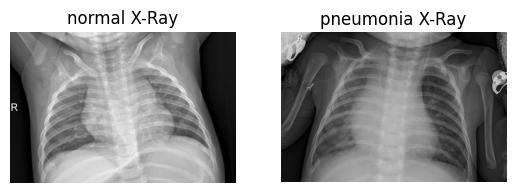

In [56]:
##### 문제2 코드 ######
datasets = ['test', 'val', 'train']

# 무작위로 정상, 폐렴 이미지를 추출할 수 있도록 random 사용
def visualize_random_images(dataset):
    normal_dir = os.path.join(data_dir, dataset, labels[0])
    pneumonia_dir = os.path.join(data_dir, dataset, labels[1])

for dataset in datasets:
    visualize_random_images(dataset)

# 정상, 폐렴 x-ray가 행 1개, 열 2개로 나오도록 subplot 설정
plt.subplot(1, 2, 1)
plt.imshow(normal_img)
plt.title('normal X-Ray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img)
plt.title('pneumonia X-Ray')
plt.axis('off')

plt.show()




## Train, validation, test 데이터 분리

In [60]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

np.random.shuffle(train)

for data, label in train[:1600]:
    X_train.append(data)
    y_train.append(label)

for data, label in train[1600:2000]:
    X_val.append(data)
    y_val.append(label)

for data, label in test:
    X_test.append(data)
    y_test.append(label)

## 데이터 정규화(Normalization)

### [문제3] 아래 문제의 답을 작성하세요.
-  이미지 데이터의 값을 0~1사이의 값으로 정규화하기 위해서 나눠야하는 숫자는 무엇인가?

- 답 : 255

In [61]:
##### 문제3의 답을 기입하세요

X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1600, 128, 128, 3)
(400, 128, 128, 3)
(624, 128, 128, 3)


## CNN 모델 훈련 및 예측

In [62]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [63]:
from tensorflow.keras import layers, models

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

### [문제4] 다음 조건에 해당하는 모델을 구현하세요.


1. 해당 모델은 4개의 컨볼루션 레이어 블록으로 구성되어 있다.
2. 각 레이어 블록은 2D convolution layer, max pooling layer, dropout layer로 구성되어 있다.
3. convolution layer의 조건은 아래와 같다.
  - 첫 번째 레이어 블록 내 convolution layer의 필터 개수 : 32
  - 필터 크기 : 3x3
  - 패딩 조건 : same
  - 활성화 함수 : relu
  - 이후 convolution layer 필터는 2배씩 증가
4. Max pooling layer의 필터 크기는 2x2이다.
5. 각 레이어 블록마다 랜덤하게 비활성화할 뉴런의 비율은 30%이다.
6. 모든 합성곱 연산이 끝난 후 다차원 특징 맵을 1차원으로 평탄화한다.
7. 이후 마지막 컨볼루션 레이어 블록의 필터와 같은 수의 뉴런 개수를 가진 fully connected layer를 연결한다. 이때 활성화 함수는 relu를 사용한다.
8. 시그모이드 활성화 함수를 사용하여 확률 값을 출력하는 출력 레이어를 추가한다.

In [65]:
model = models.Sequential([
    ##### 문제4 코드 ######
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = X_train.shape[1:]),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [66]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
50/50 [==============================] - 90s 2s/step - loss: 0.5970 - accuracy: 0.7212 - precision: 0.7302 - recall: 0.9821 - auc: 0.5363 - val_loss: 0.6578 - val_accuracy: 0.7400 - val_precision: 0.7400 - val_recall: 1.0000 - val_auc: 0.6876 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - 80s 2s/step - loss: 0.5221 - accuracy: 0.7331 - precision: 0.7331 - recall: 0.9991 - auc: 0.7743 - val_loss: 0.6196 - val_accuracy: 0.8675 - val_precision: 0.8932 - val_recall: 0.9324 - val_auc: 0.9343 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - 86s 2s/step - loss: 0.3489 - accuracy: 0.8537 - precision: 0.8585 - recall: 0.9582 - auc: 0.9077 - val_loss: 0.4931 - val_accuracy: 0.8200 - val_precision: 0.9912 - val_recall: 0.7635 - val_auc: 0.9654 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - 80s 2s/step - loss: 0.2554 - accuracy: 0.8944 - precision: 0.9175 - recall: 0.9402 - auc: 0.9493 - val_loss: 0.5315 - val_accuracy: 0.7

## 성능 확인

In [67]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, 1])
        else:
            plt.ylim([0.5,1.01])

        plt.legend()

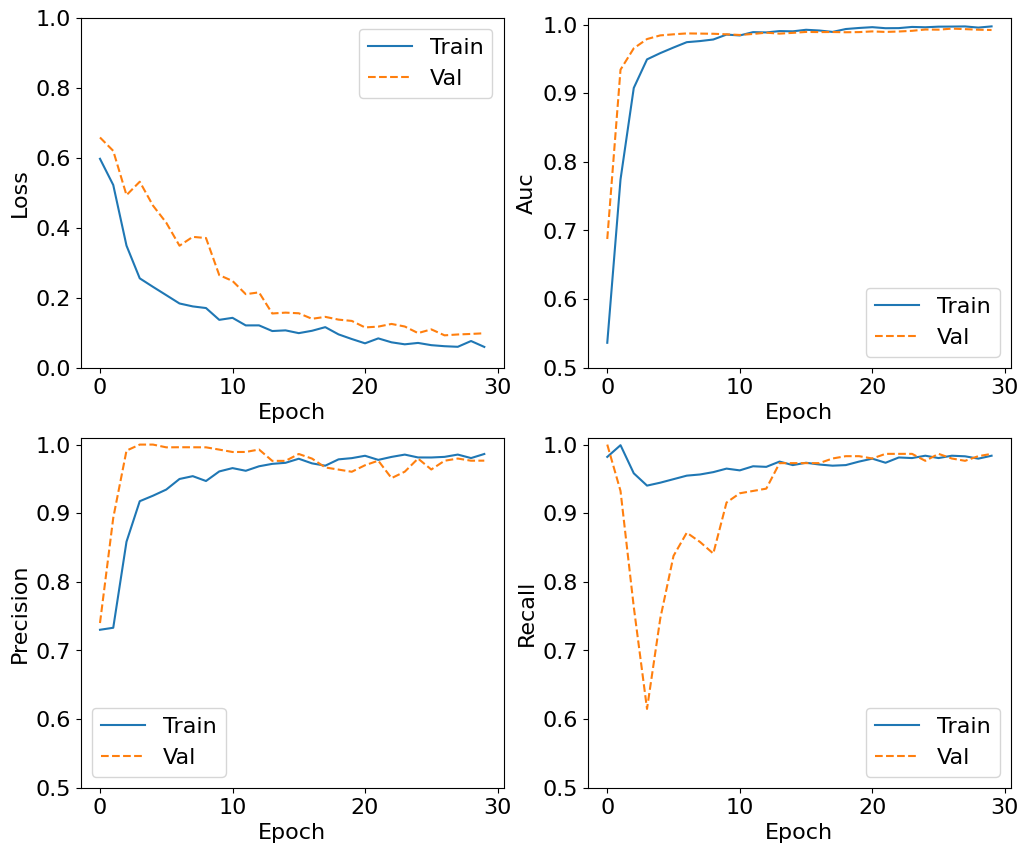

In [68]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=16)
rcParams['figure.figsize'] = 12, 10
plot_metrics(history)

In [69]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])

In [70]:
results = model.evaluate(X_test, y_test, verbose=0)
print("Result (CNN Model)")
for name, value in zip(model.metrics_names, results):
    print(f'{name}:  {value:.4f}')
print()

Result (CNN Model)
loss:  0.7587
accuracy:  0.7452
precision:  0.7135
recall:  0.9897
auc:  0.8965



In [72]:
sns.set(font_scale=1.8)
plot_cm(y_test, test_predictions)

NameError: name 'test_predictions' is not defined

In [73]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    auc = sklearn.metrics.roc_auc_score(labels, predictions)

    plt.plot(100*fp, 100*tp, label="{} (AUC = {:.3f})".format(name, auc), linewidth=2, **kwargs)
    plt.xlabel('False positives [%]', fontsize=20)
    plt.ylabel('True positives [%]', fontsize=20)
    plt.title('ROC curve', fontsize=20)
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [74]:
plot_roc("Train", y_train, train_predictions, color=colors[0])
plot_roc("Test", y_test, test_predictions, color=colors[1], linestyle='--')
plt.legend(loc='lower right');

NameError: name 'train_predictions' is not defined

### [문제5] 아래 질문에 대한 답과 그 이유를 서술하세요.
- 질문 : 해당 모델은 과적합되었는가?
- 답 : 아니요.
30번 에포크 이후 검증 정확도가 0.9725, 훈련 정확도가 0.9781로 크게 차이가 없기 때문에 과대적합이 많이 일어나지 않았다고 판단할 수 있다.
